In [1]:
# %reset

# Data prepartion
These scripts load the reports from source code metrics (NDepend), repository mining (PyDriller) and profiler (dotTrace) and filter and change the methods name in order to match the metrics. 

Import libraries

In [2]:
import csv
from xml.etree import ElementTree
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import StrMethodFormatter


Locations:

In [3]:
source_code_metrics_file = "C:/Users/aprodea/work/experiment-projects/sharex/ndepend/export_query_v12.csv"
repo_mining_file = "C:/Users/aprodea/work/experiment-projects/sharex/commits/commits-to-v12.0.0a.csv"
usage_folder = "C:/Users/aprodea/work/experiment-projects/sharex/profiler/usage/"

# source_code_metrics_file = "C:/Users/aprodea/work/metrics-tax-compare/ndepend/export_query_v111.csv"
# repo_mining_file = "C:/Users/aprodea/work/metrics-tax-compare/commits/commits-tax-to-1.1.1_june_2017.csv"
# usage_folder = "C:/Users/aprodea/work/metrics-tax-compare/profiler/usage"

repo_mining_file_for_chglines = "C:/Users/aprodea/work/experiment-projects/sharex/commits/commits-from-v12.0.0a.csv"
# repo_mining_file_for_chglines = "C:/Users/aprodea/work/metrics-tax-compare/commits/commits-tax-from-1.1.1_june_2017.csv"

test_coverage_file = None
# test_coverage_file = "C:/Users/aprodea/work/metrics-tax-compare/coverage/unit_tests.xml"

save_to_folder = "C:/Users/aprodea/work/experiment-projects/sharex/analysis/v12a/merged/"
# save_to_folder = "C:/Users/aprodea/work/metrics-tax-compare/research_v111/"

Helper methods to replace parameter types

In [4]:
type_dict = {'int': 'Int32', 'long': 'Int64', 'bool': 'Boolean', 'byte': 'Byte', 'decimal': 'Decimal',
             'string': 'String', 'double': 'Double', 'object': 'Object', 'char': 'Char', 'uint': 'UInt32',
             'float': 'Single', 'ushort': 'UInt16'}
def get_type_outbox(param_type):
    if param_type in type_dict:
        return type_dict[param_type]
    return param_type


def replace_by_token(param_type):
    delims = "<>,[]()"
    token = ''
    new_param_type = ''
    found_delim = False
    for i in range(len(param_type)):
        if param_type[i] in delims:
            found_delim = True
            replace = get_type_outbox(token)
            token = ''
            new_param_type += replace + param_type[i]
        else:
            token = token + param_type[i]
    if found_delim is False:
        return get_type_outbox(param_type)
    return new_param_type


def replace_types(param_type):
    for k,v in type_dict.items():
        if k in param_type:
            param_type = param_type.replace(k, v)
    return param_type


def ctor_to_class_name(value):
    if "..ctor" in value:
        idx2 = value.rfind("..ctor")
        idx1 = value[:idx2].rfind(".")
        cls_name = value[idx1:idx2]
        # in case the class has generics keep only the class name
        if '<' in cls_name:
            cls_name = cls_name[:cls_name.find('<')]
        value = value.replace("..ctor", cls_name)
    if "..cctor" in value:
        idx2 = value.rfind("..cctor")
        idx1 = value[:idx2].rfind(".")
        cls_name = value[idx1:idx2]
        # in case the class has generics keep only the class name
        if '<' in cls_name:
            cls_name = cls_name[:cls_name.find('<')]
        value = value.replace("..cctor", cls_name)
    return value

## Source code metrics

In [5]:
def change_method_name_metrics(method):
    # for inner classes
    method = method.replace('+', '.')
    method = method.replace('&', '')
    return method


def get_code_metrics_data(file):
    data = pd.read_csv(file, sep=';', decimal=',')
    data['FullName'] = data['FullName'].apply(change_method_name_metrics)
    return data

Load data

In [6]:
metrics_data = get_code_metrics_data(source_code_metrics_file)
metrics_data

,Name,FullName,NbLinesOfCode,CyclomaticComplexity,ILCyclomaticComplexity,ILNestingDepth,Level,IsConstructor,IsClassConstructor,IsAbstract,...,IsMethod,PercentageComment,NbOverloads,NbParameters,NbVariables,NbMethodsCalled,NbMethodsCalledThirdParty,NbMethodsCalledInternal,NbMethodsCallingMe,Rank
0,get_Name(),"<>f__AnonymousType0<<Name>j__TPar,<Description...",NaN,NaN,1.0,0.0,1.0,False,False,False,...,True,NaN,1,0,0.0,0,0,0,1,0.2078
1,get_Description(),"<>f__AnonymousType0<<Name>j__TPar,<Description...",NaN,NaN,1.0,0.0,1.0,False,False,False,...,True,NaN,1,0,0.0,0,0,0,1,0.2078
2,".ctor(<Name>j__TPar,<Description>j__TPar)","<>f__AnonymousType0<<Name>j__TPar,<Description...",0.0,NaN,1.0,0.0,1.0,True,False,False,...,True,NaN,1,2,0.0,1,1,0,1,0.2078
3,Equals(Object),"<>f__AnonymousType0<<Name>j__TPar,<Description...",0.0,NaN,3.0,2.0,1.0,False,False,False,...,True,NaN,1,1,1.0,2,2,0,0,0.1500
4,GetHashCode(),"<>f__AnonymousType0<<Name>j__TPar,<Description...",0.0,NaN,1.0,0.0,1.0,False,False,False,...,True,NaN,1,0,0.0,2,2,0,0,0.1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13354,.ctor(),ShareX.NativeMessagingHost.NativeMessagingInpu...,NaN,NaN,1.0,0.0,1.0,True,False,False,...,True,NaN,1,0,0.0,1,1,0,0,0.1500
13355,Main(String[]),ShareX.NativeMessagingHost.Program.Main(String[]),5.0,3.0,4.0,2.0,11.0,False,False,False,...,True,0.0,1,1,2.0,3,1,2,0,0.1500
13356,Run(),ShareX.NativeMessagingHost.Program.Run(),14.0,6.0,6.0,3.0,10.0,False,False,False,...,True,0.0,1,0,10.0,12,5,7,1,0.4337
13357,GetInput(),ShareX.NativeMessagingHost.Program.GetInput(),7.0,1.0,1.0,0.0,1.0,False,False,False,...,True,0.0,1,0,5.0,5,5,0,1,0.2995


Prepare the data by excluding setter, getters, anonymous types and methods with LOC not set or 0.
The final dataset contains the set of metrics used in the research.

In [7]:
metrics_data["NbLinesOfCode"].replace({0: np.nan}, inplace=True)

no_getters = metrics_data['IsPropertyGetter'] == False
no_setters = metrics_data['IsPropertySetter'] == False
no_operators = metrics_data['IsOperator'] == False
no_empty_method = metrics_data['NbLinesOfCode'].notna()
annonymous = metrics_data['FullName'].str.contains("f__AnonymousType")

filtered_metrics_data = metrics_data.copy()
filtered_metrics_data = filtered_metrics_data[no_setters & no_getters & no_operators & no_empty_method & ~annonymous].reset_index()

sc_metrics_data = filtered_metrics_data[["FullName", "NbLinesOfCode", "CyclomaticComplexity", "NbParameters", "NbVariables",
                                "ILNestingDepth", "NbMethodsCallingMe", "NbMethodsCalledInternal"]].copy()
sc_metrics_data.columns = ["Method", "LOC", "CC", "NP", "NV", "NEST", "Ca", "Ce"]

# Constructors are listed as 'ctor' or 'cctor', replace these with the class name (the actual name of the constructor)
sc_metrics_data['Method'] = sc_metrics_data['Method'].apply(ctor_to_class_name)
sc_metrics_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce
0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,2.0,1.0,1,0.0,0.0,5,0
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1.0,1.0,0,0.0,0.0,1,2
2,ShareX.ScreenCaptureLib.WindowInfo.ToString(),1.0,1.0,0,1.0,0.0,0,1
3,ShareX.HelpersLib.CustomToolStripProfessionalR...,2.0,1.0,0,0.0,0.0,2,0
4,ShareX.HelpersLib.LabeledComboBox.add_Selected...,1.0,1.0,1,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...
3694,ShareX.Setup.Program.UploadLatestFile(),5.0,3.0,0,2.0,1.0,1,2
3695,ShareX.Setup.Program.Program(),4.0,1.0,0,0.0,0.0,0,0
3696,ShareX.NativeMessagingHost.Program.Main(String[]),5.0,3.0,1,2.0,2.0,0,2
3697,ShareX.NativeMessagingHost.Program.Run(),14.0,6.0,0,10.0,3.0,1,7


## Repository mining metrics

In [8]:
def change_method_name_commits(method):
    if method is np.nan:
        return method
    
    method = method.replace('::', '.')
    start_parameters = method.rfind('(')
    method_name = method[:start_parameters]
    parameters_text = method[start_parameters:]
    if len(parameters_text) > 2:
        parameters_text = parameters_text[1:-1]  # remove ()
        parameters = parameters_text.split(', ')
        params_types = []
        for param in parameters:
            # remove potential spaces from start and end
            if "=" in param:
                param = param[:param.find("=")]
            if "." in param:
                # System.Uri _ -> Uri
                param = param[param.rfind(".") + 1:]
            param = param.strip(" ")
            p = param.split(' ')
            if " ? " in param:
                # if int ? _ -> Nullable<Int32>
                p_t = replace_by_token(p[0])
                param_type = "Nullable<" + p_t + ">"
                if "[]" in ''.join(p[0:-1]):
                    param_type = param_type + "[]"
            else:
                start = 0
                end = -1
                if (p[0] == "params") or (p[0] == "this") or (p[0] == "out") or (p[0] == "in") or (p[0] == "ref"):
                    # if params string [] _ -> String[] or params Func<T,object> [] _ -> Func<T,Object>[]
                    start = 1
                p_t = ''.join(p[start:end])
                param_type = replace_by_token(p_t)
                if (p[0] == "out") or (p[0] == "ref"):  # example with in modifier is missing
                    # out T returnedValue -> T&  or ref DateTime currencyDate -> DateTime&
                    param_type = param_type  # + '&'

            params_types.append(param_type)
        parameters_text = '(' + ','.join(params_types) + ')'

    new_name = method_name + parameters_text
    return new_name


def get_change_metrics_data(file):
    data = pd.read_csv(file, sep=';')
    data['Method_Parsed'] = data['Method'].apply(change_method_name_commits)
    return data

Load change metrics data

In [9]:
change_data = get_change_metrics_data(repo_mining_file)
change_data

,Full_path,Filename,Method,Changes,ChgLines,Method_Parsed
0,ShareX\ApplicationConfig.cs,ApplicationConfig.cs,ShareX::ApplicationConfig::ApplicationConfig(),1,0,ShareX.ApplicationConfig.ApplicationConfig()
1,ShareX\ApplicationConfig.cs,ApplicationConfig.cs,ShareX::ApplicationConfig::List<HotkeyType>(),3,1,ShareX.ApplicationConfig.List<HotkeyType>()
2,ShareX\Controls\HotkeySelectionControl.Designe...,HotkeySelectionControl.Designer.cs,ShareX::HotkeySelectionControl::Dispose( bool ...,1,0,ShareX.HotkeySelectionControl.Dispose(Boolean)
3,ShareX\Controls\HotkeySelectionControl.Designe...,HotkeySelectionControl.Designer.cs,ShareX::HotkeySelectionControl::InitializeComp...,7,32,ShareX.HotkeySelectionControl.InitializeCompon...
4,ShareX\Controls\HotkeySelectionControl.cs,HotkeySelectionControl.cs,ShareX::HotkeySelectionControl::if( selected),1,0,ShareX.HotkeySelectionControl.if()
...,...,...,...,...,...,...
5628,ShareX.HelpersLib\Input\HotkeyForm.cs,HotkeyForm.cs,ShareX.HelpersLib::HotkeyForm::RegisterHotkey(...,1,0,ShareX.HelpersLib.HotkeyForm.RegisterHotkey(Ho...
5629,ShareX.HelpersLib\Input\HotkeyForm.cs,HotkeyForm.cs,ShareX.HelpersLib::HotkeyForm::UnregisterHotke...,1,0,ShareX.HelpersLib.HotkeyForm.UnregisterHotkey(...
5630,ShareX.HelpersLib\Input\HotkeyForm.cs,HotkeyForm.cs,ShareX.HelpersLib::HotkeyForm::WndProc( ref Me...,1,0,ShareX.HelpersLib.HotkeyForm.WndProc(Message)
5631,ShareX.HelpersLib\Input\HotkeyForm.cs,HotkeyForm.cs,ShareX.HelpersLib::HotkeyForm::OnKeyPressed( u...,1,0,ShareX.HelpersLib.HotkeyForm.OnKeyPressed(UInt...


Read data for number of changed lines

In [10]:
if repo_mining_file_for_chglines is not None:
    change_lines_data = get_change_metrics_data(repo_mining_file_for_chglines)
    change_lines_data['Previous_Method_Parsed'] = change_lines_data['Previous_name'].apply(change_method_name_commits)
    change_lines_data = change_lines_data[['Method_Parsed', 'Previous_Method_Parsed', 'ChgLines']]
    change_lines_data.to_csv(save_to_folder + "change_lines.csv", sep=';', index=False)

In [60]:
change_lines_data

,Method_Parsed,Previous_Method_Parsed,ChgLines
0,ShareX.ApplicationConfig.ApplicationConfig(),ShareX.ApplicationConfig.ApplicationConfig(),0
1,ShareX.ApplicationConfig.List<HotkeyType>(),ShareX.ApplicationConfig.List<HotkeyType>(),0
2,ShareX.HotkeySelectionControl.Dispose(Boolean),ShareX.HotkeySelectionControl.Dispose(Boolean),0
3,ShareX.HotkeySelectionControl.InitializeCompon...,ShareX.HotkeySelectionControl.InitializeCompon...,1
4,ShareX.HotkeySelectionControl.if(),ShareX.HotkeySelectionControl.if(),0
...,...,...,...
5143,ShareX.ThumbnailSizeForm.Dispose(Boolean),NaN,0
5144,ShareX.ThumbnailSizeForm.InitializeComponent(),NaN,0
5145,ShareX.ThumbnailSizeForm.ThumbnailSizeForm(),NaN,0
5146,"ShareX.ThumbnailSizeForm.btnOK_Click(Object,Ev...",NaN,0


In [59]:
change_lines_data_org = get_change_metrics_data(repo_mining_file_for_chglines)
change_lines_data_org

,Full_path,Filename,Method,Changes,ChgLines,Previous_name,Method_Parsed
0,ShareX\ApplicationConfig.cs,ApplicationConfig.cs,ShareX::ApplicationConfig::ApplicationConfig(),0,0,ShareX::ApplicationConfig::ApplicationConfig(),ShareX.ApplicationConfig.ApplicationConfig()
1,ShareX\ApplicationConfig.cs,ApplicationConfig.cs,ShareX::ApplicationConfig::List<HotkeyType>(),0,0,ShareX::ApplicationConfig::List<HotkeyType>(),ShareX.ApplicationConfig.List<HotkeyType>()
2,ShareX\Controls\HotkeySelectionControl.Designe...,HotkeySelectionControl.Designer.cs,ShareX::HotkeySelectionControl::Dispose( bool ...,0,0,ShareX::HotkeySelectionControl::Dispose( bool ...,ShareX.HotkeySelectionControl.Dispose(Boolean)
3,ShareX\Controls\HotkeySelectionControl.Designe...,HotkeySelectionControl.Designer.cs,ShareX::HotkeySelectionControl::InitializeComp...,1,1,ShareX::HotkeySelectionControl::InitializeComp...,ShareX.HotkeySelectionControl.InitializeCompon...
4,ShareX\Controls\HotkeySelectionControl.cs,HotkeySelectionControl.cs,ShareX::HotkeySelectionControl::if( selected),0,0,ShareX::HotkeySelectionControl::if( selected),ShareX.HotkeySelectionControl.if()
...,...,...,...,...,...,...,...
5143,ShareX\Forms\ThumbnailSizeForm.Designer.cs,ThumbnailSizeForm.Designer.cs,ShareX::ThumbnailSizeForm::Dispose( bool dispo...,1,0,NaN,ShareX.ThumbnailSizeForm.Dispose(Boolean)
5144,ShareX\Forms\ThumbnailSizeForm.Designer.cs,ThumbnailSizeForm.Designer.cs,ShareX::ThumbnailSizeForm::InitializeComponent(),1,0,NaN,ShareX.ThumbnailSizeForm.InitializeComponent()
5145,ShareX\Forms\ThumbnailSizeForm.cs,ThumbnailSizeForm.cs,ShareX::ThumbnailSizeForm::ThumbnailSizeForm(),2,0,NaN,ShareX.ThumbnailSizeForm.ThumbnailSizeForm()
5146,ShareX\Forms\ThumbnailSizeForm.cs,ThumbnailSizeForm.cs,ShareX::ThumbnailSizeForm::btnOK_Click( object...,1,0,NaN,"ShareX.ThumbnailSizeForm.btnOK_Click(Object,Ev..."


In [62]:
change_lines_data_org['Previous_name'].isna().sum()

1192

In [64]:
diff_chg = change_data[~change_data['Method'].isin(change_lines_data_org['Previous_name'])]
diff_chg

,Full_path,Filename,Method,Changes,ChgLines,Method_Parsed
31,ShareX\Forms\AboutForm.cs,AboutForm.cs,ShareX::AboutForm::cLogo_Draw( Graphics g),4,22,ShareX.AboutForm.cLogo_Draw(Graphics)
32,ShareX\Forms\AboutForm.cs,AboutForm.cs,ShareX::AboutForm::cLogo_MouseDown( object sen...,10,50,"ShareX.AboutForm.cLogo_MouseDown(Object,MouseE..."
33,ShareX\Forms\AboutForm.cs,AboutForm.cs,ShareX::AboutForm::bounceTimer_Tick( object se...,3,7,"ShareX.AboutForm.bounceTimer_Tick(Object,Event..."
34,ShareX\Forms\AboutForm.cs,AboutForm.cs,ShareX::AboutForm::RunEasterEgg(),2,4,ShareX.AboutForm.RunEasterEgg()
89,ShareX\Forms\AutoCaptureForm.cs,AutoCaptureForm.cs,ShareX::AutoCaptureForm::SelectRegion( TaskSet...,4,3,ShareX.AutoCaptureForm.SelectRegion(TaskSettings)
...,...,...,...,...,...,...
5563,ShareX.ScreenCaptureLib\Shapes\Drawing\CursorD...,CursorDrawingShape.cs,ShareX.ScreenCaptureLib::CursorDrawingShape::D...,2,1,ShareX.ScreenCaptureLib.CursorDrawingShape.Dis...
5588,ShareX.UploadersLib\ImageUploaders\GooglePhoto...,GooglePhotos.cs,ShareX.UploadersLib.ImageUploaders::GooglePhot...,5,1,ShareX.UploadersLib.ImageUploaders.GooglePhoto...
5602,ShareX\StartupManagers\StartupManagerFactory.cs,StartupManagerFactory.cs,ShareX.StartupManagers::StartupManagerFactory:...,5,9,ShareX.StartupManagers.StartupManagerFactory.C...
5603,ShareX\StartupManagers\StartupManagerFactory.cs,StartupManagerFactory.cs,ShareX.StartupManagers::StartupManagerFactory:...,1,0,ShareX.StartupManagers.StartupManagerFactory.if()


In [74]:
change_data[~change_data['Method_Parsed'].isin(change_lines_data['Previous_Method_Parsed'])]

,Full_path,Filename,Method,Changes,ChgLines,Method_Parsed
31,ShareX\Forms\AboutForm.cs,AboutForm.cs,ShareX::AboutForm::cLogo_Draw( Graphics g),4,22,ShareX.AboutForm.cLogo_Draw(Graphics)
32,ShareX\Forms\AboutForm.cs,AboutForm.cs,ShareX::AboutForm::cLogo_MouseDown( object sen...,10,50,"ShareX.AboutForm.cLogo_MouseDown(Object,MouseE..."
33,ShareX\Forms\AboutForm.cs,AboutForm.cs,ShareX::AboutForm::bounceTimer_Tick( object se...,3,7,"ShareX.AboutForm.bounceTimer_Tick(Object,Event..."
34,ShareX\Forms\AboutForm.cs,AboutForm.cs,ShareX::AboutForm::RunEasterEgg(),2,4,ShareX.AboutForm.RunEasterEgg()
89,ShareX\Forms\AutoCaptureForm.cs,AutoCaptureForm.cs,ShareX::AutoCaptureForm::SelectRegion( TaskSet...,4,3,ShareX.AutoCaptureForm.SelectRegion(TaskSettings)
...,...,...,...,...,...,...
5563,ShareX.ScreenCaptureLib\Shapes\Drawing\CursorD...,CursorDrawingShape.cs,ShareX.ScreenCaptureLib::CursorDrawingShape::D...,2,1,ShareX.ScreenCaptureLib.CursorDrawingShape.Dis...
5588,ShareX.UploadersLib\ImageUploaders\GooglePhoto...,GooglePhotos.cs,ShareX.UploadersLib.ImageUploaders::GooglePhot...,5,1,ShareX.UploadersLib.ImageUploaders.GooglePhoto...
5602,ShareX\StartupManagers\StartupManagerFactory.cs,StartupManagerFactory.cs,ShareX.StartupManagers::StartupManagerFactory:...,5,9,ShareX.StartupManagers.StartupManagerFactory.C...
5603,ShareX\StartupManagers\StartupManagerFactory.cs,StartupManagerFactory.cs,ShareX.StartupManagers::StartupManagerFactory:...,1,0,ShareX.StartupManagers.StartupManagerFactory.if()


In [75]:
sc_metrics_data[sc_metrics_data['Method'].isin(change_lines_data['Previous_Method_Parsed'])]


,Method,LOC,CC,NP,NV,NEST,Ca,Ce
0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,2.0,1.0,1,0.0,0.0,5,0
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1.0,1.0,0,0.0,0.0,1,2
2,ShareX.ScreenCaptureLib.WindowInfo.ToString(),1.0,1.0,0,1.0,0.0,0,1
6,ShareX.HelpersLib.LabeledComboBox.LabeledCombo...,3.0,1.0,0,0.0,0.0,1,1
7,ShareX.HelpersLib.LabeledComboBox.Add(Object),1.0,1.0,1,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...
3679,ShareX.Setup.Helpers.CopyFiles(IEnumerable<Str...,9.0,3.0,2,5.0,2.0,2,0
3685,"ShareX.Setup.Helpers.CheckArguments(String[],S...",8.0,5.0,2,6.0,3.0,1,0
3696,ShareX.NativeMessagingHost.Program.Main(String[]),5.0,3.0,1,2.0,2.0,0,2
3697,ShareX.NativeMessagingHost.Program.Run(),14.0,6.0,0,10.0,3.0,1,7


In [ ]:
df = pd.merge(change_data, change_lines_data[['Previous_Method_Parsed', 'ChgLines']], how='inner', left_on='Method', right_on='Previous_Method_Parsed')
df

## Profiler metrics

In [11]:
def change_method_name_usage(method):
    if '`' in method:
        idx = method.find('`')
        part = method[idx+1:]
        method = method[:idx] + part[part.find('.'):]
    params_start = method.rfind('(')
    method_name = method[:params_start]
    params_text = method[params_start:]
    if len(params_text) > 2:
        parameters_text = params_text[1:-1]  # remove ()
        parameters = parameters_text.split(',')
        params_types = []
        for param in parameters:
            param = param.strip(" ")
            if param.startswith("params "):
                param = param[len("params"):]
            elif param.startswith("out "):
                param = param[len("out"):]
            elif param.startswith("ref "):
                param = param[len("ref"):]
            param = param.strip(" ")
            params_types.append(param)
        params_text = '(' + ','.join(params_types) + ')'
        
    # for inner classes
    method_name = method_name.replace('+', '.')

    new_name = method_name + params_text
    return new_name


def get_profiler_metrics_data(file):
    calls_metrics = {'Method': [], 'Calls': []}
    root = ElementTree.parse(file).getroot()
    for type_tag in root.findall('Function'):
        method = type_tag.get('FQN')
        calls = type_tag.get('Calls')

        calls_metrics['Method'].append(str(method))
        calls_metrics['Calls'].append(int(calls))
    df = pd.DataFrame(data=calls_metrics)
    df['Method'] = df['Method'].apply(change_method_name_usage)
    return df


def get_all_profiler_metrics_data(folder):
    calls_dfs = []
    with os.scandir(folder) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.endswith('.xml'):
                full_path = os.path.join(folder, entry.name)
                calls_dfs.append(get_profiler_metrics_data(full_path))
    df = pd.concat(calls_dfs)
    df = df.groupby('Method')['Calls'].sum().reset_index()
    return df


Load the profiler metrics and replace 'ctor' and 'cctor' with the class name.

In [12]:
calls_data = get_all_profiler_metrics_data(usage_folder)

calls_data['Method'] = calls_data['Method'].apply(ctor_to_class_name)
calls_data

,Method,Calls
0,ShareX.AboutForm.AboutForm(),2
1,"ShareX.AboutForm.AboutForm_Shown(Object,EventA...",2
2,ShareX.AboutForm.Dispose(Boolean),2
3,ShareX.AboutForm.InitializeComponent(),2
4,"ShareX.AboutForm.btnClose_Click(Object,EventArgs)",2
...,...,...
3497,ShareX.WorkerTask.add_UploadStarted(TaskEventH...,39
3498,ShareX.WorkerTask.add_UploadersConfigWindowReq...,39
3499,ShareX.WorkerTask.get_IsWorking(),1707
3500,ShareX.WorkerTask.get_StopRequested(),1


Extra method to collect the metrics from Visual Studio Performance Profiler report

In [13]:
def get_vs_profiler_metrics_data():
    file = "C:/Users/aprodea/work/profiler/vs/Report20201015-1152_FunctionSummary.xml"
    calls_metrics = {'Method': [], 'Calls': [], 'SourceFile': []}
    root = ElementTree.parse(file).getroot()
    for type_tag in root.findall('FunctionSummary/Function'):
        method = type_tag.get('FunctionName')
        calls = type_tag.get('NumCalls')
        source_file = type_tag.get('SourceFile')
        # line_no = type_tag.get('LineNumber')

        if method.startswith('GES_GRT'):
            calls_metrics['Method'].append(str(method))
            calls_metrics['Calls'].append(int(calls))
            calls_metrics['SourceFile'].append(str(source_file))

    return pd.DataFrame(data=calls_metrics)

## Test coverage

In [14]:
test_coverage = {'Method': [], 'TotalStatements': [], 'CoveredStatements': []}

def get_children(all_path, element):
    name = element.get("Name")
    if element.tag in ['Method', 'Constructor']:
        all_path += name
        method_name = str(all_path)
        idx = method_name.rfind(':')
        if idx > 0:
            method_name = method_name[:idx]
        test_coverage['Method'].append(method_name)
        test_coverage['TotalStatements'].append(int(element.get("TotalStatements")))
        test_coverage['CoveredStatements'].append(str(element.get("CoveredStatements")))
    elif name is not None:
        all_path += name + '.'
        
    for el in list(element):
        get_children(all_path, el)


def change_name_coverage(method):
    start_parameters = method.rfind('(')
    method_name = method[:start_parameters]
    parameters_text = method[start_parameters:]
    if len(parameters_text) > 2:
        parameters_text = parameters_text.replace('params ', '')
        parameters_text = parameters_text.replace('out ', '')
        parameters_text = parameters_text.replace('ref ', '')
        parameters_text = parameters_text.replace('in ', '')
        parameters_text = replace_by_token(parameters_text)
        
    method_name = method_name.replace('+', '.')

    new_name = method_name + parameters_text
    return new_name
        
        
def get_test_coverage_data(test_coverage_file):
    root = ElementTree.parse(file).getroot()

    for type_tag in root.findall('Project/*'):
        get_children('', type_tag)

    df = pd.DataFrame(data=test_coverage)
    df['Method'] = df['Method'].apply(change_name_coverage)
    return df

Load test coverage data

In [15]:
if test_coverage_file is not None:
    test_coverage_data = get_test_coverage_data(test_coverage_file)
    test_coverage_data
else:
    test_coverage_data = None

Write the resulting datasets to file

In [16]:
sc_metrics_data.to_csv(save_to_folder + "subset_metrics.csv", sep=';', index=False)
calls_data.to_csv(save_to_folder + "all_calls.csv", sep=';', index=False)
change_data.to_csv(save_to_folder + "all_changes.csv", sep=';', index=False)

if test_coverage_data is not None:
    test_coverage_data.to_csv(save_to_folder + "test_coverage.csv", sep=';', index=False)

## Few checks

In [17]:
diff_ch_and_metrics = change_data[~change_data['Method_Parsed'].isin(sc_metrics_data['Method'])].dropna()
diff_ch_and_metrics.to_csv(save_to_folder + "ch_not_found_in_metrics.csv", sep=';', index=False, na_rep=0)
diff_ch_and_metrics

,Full_path,Filename,Method,Changes,ChgLines,Method_Parsed
0,ShareX\ApplicationConfig.cs,ApplicationConfig.cs,ShareX::ApplicationConfig::ApplicationConfig(),1,0,ShareX.ApplicationConfig.ApplicationConfig()
1,ShareX\ApplicationConfig.cs,ApplicationConfig.cs,ShareX::ApplicationConfig::List<HotkeyType>(),3,1,ShareX.ApplicationConfig.List<HotkeyType>()
2,ShareX\Controls\HotkeySelectionControl.Designe...,HotkeySelectionControl.Designer.cs,ShareX::HotkeySelectionControl::Dispose( bool ...,1,0,ShareX.HotkeySelectionControl.Dispose(Boolean)
3,ShareX\Controls\HotkeySelectionControl.Designe...,HotkeySelectionControl.Designer.cs,ShareX::HotkeySelectionControl::InitializeComp...,7,32,ShareX.HotkeySelectionControl.InitializeCompon...
4,ShareX\Controls\HotkeySelectionControl.cs,HotkeySelectionControl.cs,ShareX::HotkeySelectionControl::if( selected),1,0,ShareX.HotkeySelectionControl.if()
...,...,...,...,...,...,...
5597,ShareX.UploadersLib\SharingServices\SimpleURLS...,SimpleURLSharingService.cs,ShareX.UploadersLib.SharingServices::SimpleURL...,2,1,ShareX.UploadersLib.SharingServices.SimpleURLS...
5601,ShareX\StartupManagers\CentennialStartupManage...,CentennialStartupManager.cs,ShareX.StartupManagers::CentennialStartupManag...,4,2,ShareX.StartupManagers.CentennialStartupManage...
5602,ShareX\StartupManagers\StartupManagerFactory.cs,StartupManagerFactory.cs,ShareX.StartupManagers::StartupManagerFactory:...,5,9,ShareX.StartupManagers.StartupManagerFactory.C...
5603,ShareX\StartupManagers\StartupManagerFactory.cs,StartupManagerFactory.cs,ShareX.StartupManagers::StartupManagerFactory:...,1,0,ShareX.StartupManagers.StartupManagerFactory.if()


In [18]:
if test_coverage_data is not None:
    sc_metrics_data[~sc_metrics_data['Method'].isin(test_coverage_data['Method'])].dropna()

## Merging data

Select the change metrics we need and rename the columns, and sum the results (in case there are multiple rows for the same method)

In [19]:
sub_change_data = change_data[['Method_Parsed', 'Changes']]
sub_change_data.columns = ['Method', 'NChg']
sub_change_data = sub_change_data.groupby('Method')['NChg'].sum().reset_index()
sub_change_data

,Method,NChg
0,"CreateFolder(String,String,SetupJobs)",5
1,DesktopBridgeHelper.Program.GetAbsolutePath(St...,1
2,DesktopBridgeHelper.Program.Main(String[]),2
3,GreenShot.ColorPickerEventArgs.ColorPickerEven...,1
4,GreenShot.ColorPickerToolStripButton.ColorPick...,1
...,...,...
5628,UploadersLib.FTPClientForm.Client_ServerRespon...,1
5629,UploadersLib.HelperClasses.CustomUploaderItem....,2
5630,UploadersLib.HelperClasses.CustomUploaderItem....,4
5631,UploadersLib.URLShorteners.AdflyURLShortener.S...,2


### Merge change data to soure code metrics data

In [20]:
merged_left_ch = pd.merge(left=sc_metrics_data, right=sub_change_data, how='left', left_on='Method', right_on='Method')
merged_left_ch

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg
0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,2.0,1.0,1,0.0,0.0,5,0,1.0
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1.0,1.0,0,0.0,0.0,1,2,1.0
2,ShareX.ScreenCaptureLib.WindowInfo.ToString(),1.0,1.0,0,1.0,0.0,0,1,1.0
3,ShareX.HelpersLib.CustomToolStripProfessionalR...,2.0,1.0,0,0.0,0.0,2,0,1.0
4,ShareX.HelpersLib.LabeledComboBox.add_Selected...,1.0,1.0,1,0.0,0.0,1,0,NaN
...,...,...,...,...,...,...,...,...,...
3694,ShareX.Setup.Program.UploadLatestFile(),5.0,3.0,0,2.0,1.0,1,2,NaN
3695,ShareX.Setup.Program.Program(),4.0,1.0,0,0.0,0.0,0,0,NaN
3696,ShareX.NativeMessagingHost.Program.Main(String[]),5.0,3.0,1,2.0,2.0,0,2,5.0
3697,ShareX.NativeMessagingHost.Program.Run(),14.0,6.0,0,10.0,3.0,1,7,8.0


In [21]:
missing_ch = merged_left_ch[pd.isnull(merged_left_ch['NChg'])]
missing_ch.to_csv(save_to_folder + "missing_ch_in_merged.csv", sep=';', index=False)
missing_ch

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg
4,ShareX.HelpersLib.LabeledComboBox.add_Selected...,1.0,1.0,1,0.0,0.0,1,0,NaN
5,ShareX.HelpersLib.LabeledComboBox.remove_Selec...,1.0,1.0,1,0.0,0.0,0,0,NaN
17,ShareX.HelpersLib.ToolStripEx.ToolStripEx(),1.0,1.0,0,0.0,0.0,2,0,NaN
29,ShareX.HelpersLib.HotkeyInfo.HotkeyInfo(Keys),2.0,1.0,1,0.0,0.0,4,2,NaN
30,"ShareX.HelpersLib.HotkeyInfo.HotkeyInfo(Keys,U...",2.0,1.0,2,0.0,0.0,0,2,NaN
...,...,...,...,...,...,...,...,...,...
3691,"ShareX.Setup.Program.CreateFolder(String,Strin...",38.0,15.0,3,15.0,2.0,2,13,NaN
3692,ShareX.Setup.Program.CopyFFmpeg(String),10.0,3.0,1,4.0,1.0,1,5,NaN
3693,ShareX.Setup.Program.OpenOutputDirectory(),1.0,1.0,0,0.0,0.0,1,1,NaN
3694,ShareX.Setup.Program.UploadLatestFile(),5.0,3.0,0,2.0,1.0,1,2,NaN


In [22]:
for m in missing_ch['Method']:
    print(m)

ShareX.HelpersLib.LabeledComboBox.add_SelectedIndexChanged(EventHandler)
ShareX.HelpersLib.LabeledComboBox.remove_SelectedIndexChanged(EventHandler)
ShareX.HelpersLib.ToolStripEx.ToolStripEx()
ShareX.HelpersLib.HotkeyInfo.HotkeyInfo(Keys)
ShareX.HelpersLib.HotkeyInfo.HotkeyInfo(Keys,UInt16)
ShareX.HelpersLib.KeyboardHook.Finalize()
ShareX.HelpersLib.CodeMenuEntryActions.CodeMenuEntryActions()
ShareX.HelpersLib.ClipboardFormat.ClipboardFormat(String,String)
ShareX.HelpersLib.CodeMenu.Create<TEntry>(TextBox,TEntry[])
ShareX.HelpersLib.CodeMenu.Create<TEntry>(TextBox,TEntry[],CodeMenuItem[])
ShareX.HelpersLib.CodeMenu.Create<TEntry>(TEntry[])
ShareX.HelpersLib.ColorMatrixManager.Apply(ColorMatrix,Image,Image,Rectangle)
ShareX.HelpersLib.CMYK.CMYK(Int32,Int32,Int32,Int32,Int32)
ShareX.HelpersLib.CMYK.CMYK(Color)
ShareX.HelpersLib.ColorEventArgs.ColorEventArgs(MyColor,DrawStyle)
ShareX.HelpersLib.GradientStop.GradientStop()
ShareX.HelpersLib.HSB.HSB(Int32,Int32,Int32,Int32)
ShareX.HelpersLi

Greenshot.Drawing.Fields.Binding.DecimalDoublePercentageConverter.convert(Decimal)
Greenshot.Drawing.Fields.Binding.DecimalFloatConverter.convert(Decimal)
Greenshot.Drawing.Fields.Binding.DecimalIntConverter.convert(Decimal)
ShareX.Setup.Helpers.CopyFiles(String,String,String,String[])
ShareX.Setup.Helpers.CopyAll(String,String)
ShareX.Setup.Program.Main(String[])
ShareX.Setup.Program.CompileSetup()
ShareX.Setup.Program.CompileISSFile(String)
ShareX.Setup.Program.CreateSteamFolder()
ShareX.Setup.Program.CreateFolder(String,String,Program.SetupJobs)
ShareX.Setup.Program.CopyFFmpeg(String)
ShareX.Setup.Program.OpenOutputDirectory()
ShareX.Setup.Program.UploadLatestFile()
ShareX.Setup.Program.Program()


On the merging result; remove the generics type of methods in order to match with the method names from profiler report 

In [23]:
def remove_generics_as_in_calls(params_decl):
    new_decl = ''
    count = 0

    for i in range(len(params_decl)):
        c = params_decl[i]
        if c == '<':
            count += 1
            continue
        if c == '>':
            count -= 1
            continue
        if c == '&':
            continue
        if count == 0:
            new_decl += c

    return new_decl


merged_left_ch['Method_Parsed'] = merged_left_ch['Method'].apply(remove_generics_as_in_calls)
merged_left_ch

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,Method_Parsed
0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,2.0,1.0,1,0.0,0.0,5,0,1.0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1.0,1.0,0,0.0,0.0,1,2,1.0,ShareX.ScreenCaptureLib.WindowInfo.Activate()
2,ShareX.ScreenCaptureLib.WindowInfo.ToString(),1.0,1.0,0,1.0,0.0,0,1,1.0,ShareX.ScreenCaptureLib.WindowInfo.ToString()
3,ShareX.HelpersLib.CustomToolStripProfessionalR...,2.0,1.0,0,0.0,0.0,2,0,1.0,ShareX.HelpersLib.CustomToolStripProfessionalR...
4,ShareX.HelpersLib.LabeledComboBox.add_Selected...,1.0,1.0,1,0.0,0.0,1,0,NaN,ShareX.HelpersLib.LabeledComboBox.add_Selected...
...,...,...,...,...,...,...,...,...,...,...
3694,ShareX.Setup.Program.UploadLatestFile(),5.0,3.0,0,2.0,1.0,1,2,NaN,ShareX.Setup.Program.UploadLatestFile()
3695,ShareX.Setup.Program.Program(),4.0,1.0,0,0.0,0.0,0,0,NaN,ShareX.Setup.Program.Program()
3696,ShareX.NativeMessagingHost.Program.Main(String[]),5.0,3.0,1,2.0,2.0,0,2,5.0,ShareX.NativeMessagingHost.Program.Main(String[])
3697,ShareX.NativeMessagingHost.Program.Run(),14.0,6.0,0,10.0,3.0,1,7,8.0,ShareX.NativeMessagingHost.Program.Run()


Select the profiler metrics we need and rename the columns, and sum the results (in case there are multiple rows for the same method)

In [24]:
sub_calls_data = calls_data[['Method', 'Calls']]
sub_calls_data.columns = ['Method_calls', 'NCall']
sub_calls_data = sub_calls_data.groupby('Method_calls')['NCall'].sum().reset_index()
sub_calls_data

,Method_calls,NCall
0,ShareX.AboutForm.AboutForm(),2
1,"ShareX.AboutForm.AboutForm_Shown(Object,EventA...",2
2,ShareX.AboutForm.Dispose(Boolean),2
3,ShareX.AboutForm.InitializeComponent(),2
4,"ShareX.AboutForm.btnClose_Click(Object,EventArgs)",2
...,...,...
3447,ShareX.WorkerTask.add_UploadStarted(TaskEventH...,39
3448,ShareX.WorkerTask.add_UploadersConfigWindowReq...,39
3449,ShareX.WorkerTask.get_IsWorking(),1707
3450,ShareX.WorkerTask.get_StopRequested(),1


### Merge also the profiler metrics based on the renamed variable

In [25]:
merged_left_ca = pd.merge(left=merged_left_ch, right=sub_calls_data, how='left', left_on='Method_Parsed', right_on='Method_calls')
missing_merged_left_ca = merged_left_ca[pd.isnull(merged_left_ca['NCall'])]
merged_left_ca


,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,Method_Parsed,Method_calls,NCall
0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,2.0,1.0,1,0.0,0.0,5,0,1.0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,NaN,NaN
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1.0,1.0,0,0.0,0.0,1,2,1.0,ShareX.ScreenCaptureLib.WindowInfo.Activate(),NaN,NaN
2,ShareX.ScreenCaptureLib.WindowInfo.ToString(),1.0,1.0,0,1.0,0.0,0,1,1.0,ShareX.ScreenCaptureLib.WindowInfo.ToString(),NaN,NaN
3,ShareX.HelpersLib.CustomToolStripProfessionalR...,2.0,1.0,0,0.0,0.0,2,0,1.0,ShareX.HelpersLib.CustomToolStripProfessionalR...,NaN,NaN
4,ShareX.HelpersLib.LabeledComboBox.add_Selected...,1.0,1.0,1,0.0,0.0,1,0,NaN,ShareX.HelpersLib.LabeledComboBox.add_Selected...,ShareX.HelpersLib.LabeledComboBox.add_Selected...,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3694,ShareX.Setup.Program.UploadLatestFile(),5.0,3.0,0,2.0,1.0,1,2,NaN,ShareX.Setup.Program.UploadLatestFile(),NaN,NaN
3695,ShareX.Setup.Program.Program(),4.0,1.0,0,0.0,0.0,0,0,NaN,ShareX.Setup.Program.Program(),NaN,NaN
3696,ShareX.NativeMessagingHost.Program.Main(String[]),5.0,3.0,1,2.0,2.0,0,2,5.0,ShareX.NativeMessagingHost.Program.Main(String[]),NaN,NaN
3697,ShareX.NativeMessagingHost.Program.Run(),14.0,6.0,0,10.0,3.0,1,7,8.0,ShareX.NativeMessagingHost.Program.Run(),NaN,NaN


Drop the renamed variable and the variable from the profiler, to keep only the previous method name

In [26]:
merged_left_ca.drop(['Method_Parsed', 'Method_calls'], axis=1, inplace=True)
merged_left_ca

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,2.0,1.0,1,0.0,0.0,5,0,1.0,NaN
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),1.0,1.0,0,0.0,0.0,1,2,1.0,NaN
2,ShareX.ScreenCaptureLib.WindowInfo.ToString(),1.0,1.0,0,1.0,0.0,0,1,1.0,NaN
3,ShareX.HelpersLib.CustomToolStripProfessionalR...,2.0,1.0,0,0.0,0.0,2,0,1.0,NaN
4,ShareX.HelpersLib.LabeledComboBox.add_Selected...,1.0,1.0,1,0.0,0.0,1,0,NaN,11.0
...,...,...,...,...,...,...,...,...,...,...
3694,ShareX.Setup.Program.UploadLatestFile(),5.0,3.0,0,2.0,1.0,1,2,NaN,NaN
3695,ShareX.Setup.Program.Program(),4.0,1.0,0,0.0,0.0,0,0,NaN,NaN
3696,ShareX.NativeMessagingHost.Program.Main(String[]),5.0,3.0,1,2.0,2.0,0,2,5.0,NaN
3697,ShareX.NativeMessagingHost.Program.Run(),14.0,6.0,0,10.0,3.0,1,7,8.0,NaN


Save the resulting dataset

In [27]:
merged_left_ca.to_csv(save_to_folder + "merged.csv", sep=';', index=False)

Check to see how many rows do not have values

In [28]:
merged_left_ca.isna().sum()

Method       0
LOC          0
CC           0
NP           0
NV           0
NEST         0
Ca           0
Ce           0
NChg       578
NCall     2629
dtype: int64

Replace missing rows with 1 for change (assuming that every method had at least the initial commit), and 0 for the rest

In [29]:
merged_left_ca['NChg'].fillna(1, inplace=True)
merged_left_ca['NCall'].fillna(0, inplace=True)

In [30]:
merged_left_ca.isna().sum()

Method    0
LOC       0
CC        0
NP        0
NV        0
NEST      0
Ca        0
Ce        0
NChg      0
NCall     0
dtype: int64

In [31]:
merged_left_ca.dtypes

Method     object
LOC       float64
CC        float64
NP          int64
NV        float64
NEST      float64
Ca          int64
Ce          int64
NChg      float64
NCall     float64
dtype: object

Save the resulting dataset with filled missing variables

In [32]:
merged_left_ca.to_csv(save_to_folder + "merged_filledna.csv", sep=';', index=False)

### Merge metrics with test coverage

In [33]:
from pathlib import Path

metrics_file = save_to_folder + "merged_filledna.csv"
metrics_data = pd.read_csv(metrics_file, sep=';')

test_cov_file = save_to_folder + "test_coverage.csv"
if Path(test_cov_file).is_file():
    test_data = pd.read_csv(test_cov_file, sep=';')

    data_combined = pd.merge(metrics_data, test_data, on='Method', how='left')

    data_combined.to_csv(save_to_folder + "merged_complete.csv", sep=';', index=False)

    data_combined
else:
    data_combined = None

In [34]:
if data_combined is not None:
    print(data_combined.isna().sum())

## Check and visualise the data

In [35]:
merged_left_ca.shape

(3699, 10)

In [36]:
list_columns = merged_left_ca.columns.tolist()
list_columns.remove('Method')

In [37]:
merged_left_ca[list_columns].describe()

,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
count,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3699.000000,3.699000e+03
mean,7.984050,2.719654,1.284672,2.781292,0.979724,1.534739,2.564747,2.334144,2.283072e+03
std,24.474035,4.357419,1.202940,4.895005,1.300817,3.507864,5.436273,3.416429,2.982589e+04
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00
25%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00
50%,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
75%,7.000000,3.000000,2.000000,3.000000,2.000000,2.000000,3.000000,2.000000,1.000000e+00
max,872.000000,128.000000,11.000000,74.000000,20.000000,93.000000,217.000000,70.000000,1.491774e+06


In [38]:
merged_left_ca['LOC'].sum()

29533.0

In [39]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats


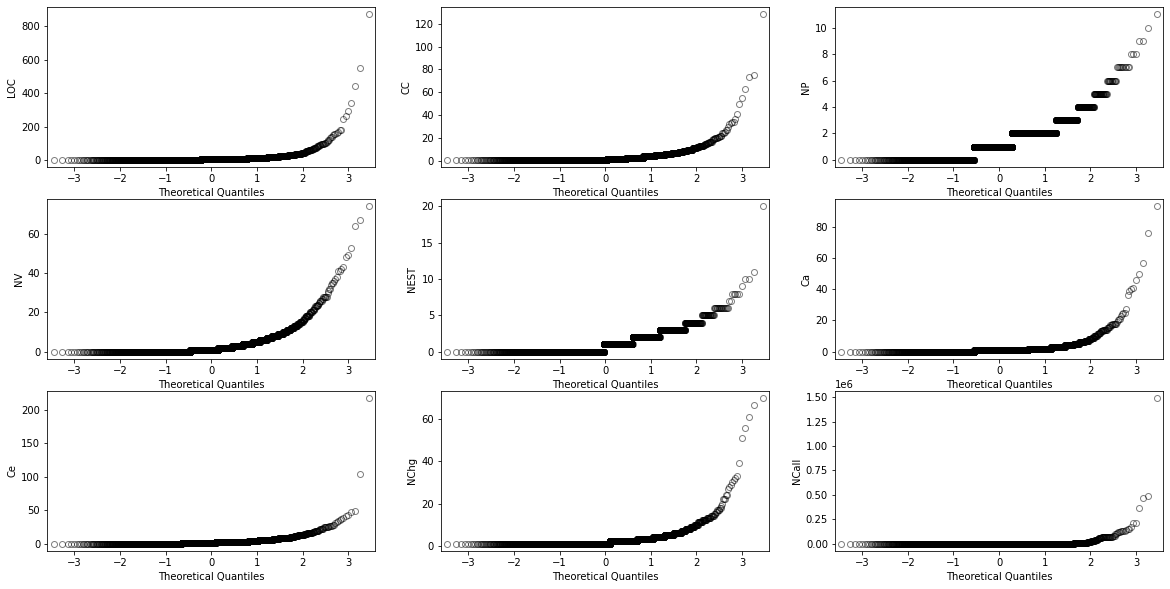

In [40]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
ax= axes.flatten()
for i in range(len(list_columns)):
    # ax = plt.subplot(10, 1, i+1)
    col_name = list_columns[i]
    sm.qqplot(merged_left_ca[col_name], marker='o', markerfacecolor='none', markeredgecolor='k', alpha=0.5,
              ax = ax[i])
    ax[i].set_ylabel(col_name)

# plt.tight_layout(pad=1.5)
# plt.show()

plt.savefig(save_to_folder + 'plots/qqplots_unscaled.pdf', bbox_inches = 'tight', pad_inches = 0)

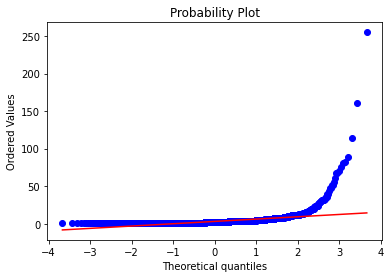

In [41]:
stats.probplot(change_data['Changes'], dist="norm", plot=plt)
plt.show()

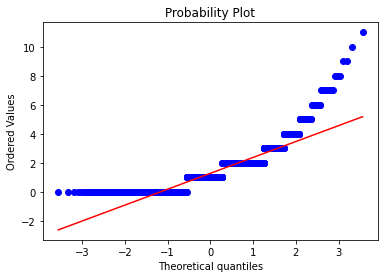

In [49]:
stats.probplot(merged_left_ca['NP'], dist="norm", plot=plt)
plt.show()

## Scale data

In [42]:
from pyclustertend import hopkins, vat, assess_tendency_by_mean_metric_score
from sklearn.preprocessing import scale, MinMaxScaler, minmax_scale, RobustScaler,robust_scale


In [43]:
X = robust_scale(merged_left_ca[list_columns])
hopkins(X, 804)

0.007561057070866569

In [44]:
X = minmax_scale(merged_left_ca[list_columns])
hopkins(X, 804)

0.013300074017495875

In [45]:
scaled_data = merged_left_ca.copy()

for col_name in list_columns:
    col = scaled_data[col_name]
    min_col, max_col = col.min(), col.max()
#     print(col_name, min_col, max_col)
    scaled_data[col_name] = (col - min_col) / (max_col - min_col)
    
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
0,ShareX.ScreenCaptureLib.WindowInfo.WindowInfo(...,0.001148,0.000000,0.090909,0.000000,0.00,0.053763,0.000000,0.000000,0.000000
1,ShareX.ScreenCaptureLib.WindowInfo.Activate(),0.000000,0.000000,0.000000,0.000000,0.00,0.010753,0.009217,0.000000,0.000000
2,ShareX.ScreenCaptureLib.WindowInfo.ToString(),0.000000,0.000000,0.000000,0.013514,0.00,0.000000,0.004608,0.000000,0.000000
3,ShareX.HelpersLib.CustomToolStripProfessionalR...,0.001148,0.000000,0.000000,0.000000,0.00,0.021505,0.000000,0.000000,0.000000
4,ShareX.HelpersLib.LabeledComboBox.add_Selected...,0.000000,0.000000,0.090909,0.000000,0.00,0.010753,0.000000,0.000000,0.000007
...,...,...,...,...,...,...,...,...,...,...
3694,ShareX.Setup.Program.UploadLatestFile(),0.004592,0.015748,0.000000,0.027027,0.05,0.010753,0.009217,0.000000,0.000000
3695,ShareX.Setup.Program.Program(),0.003444,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
3696,ShareX.NativeMessagingHost.Program.Main(String[]),0.004592,0.015748,0.090909,0.027027,0.10,0.000000,0.009217,0.057971,0.000000
3697,ShareX.NativeMessagingHost.Program.Run(),0.014925,0.039370,0.000000,0.135135,0.15,0.010753,0.032258,0.101449,0.000000


In [46]:
hopkins(scaled_data[list_columns], scaled_data.shape[0])

0.012560767581795154

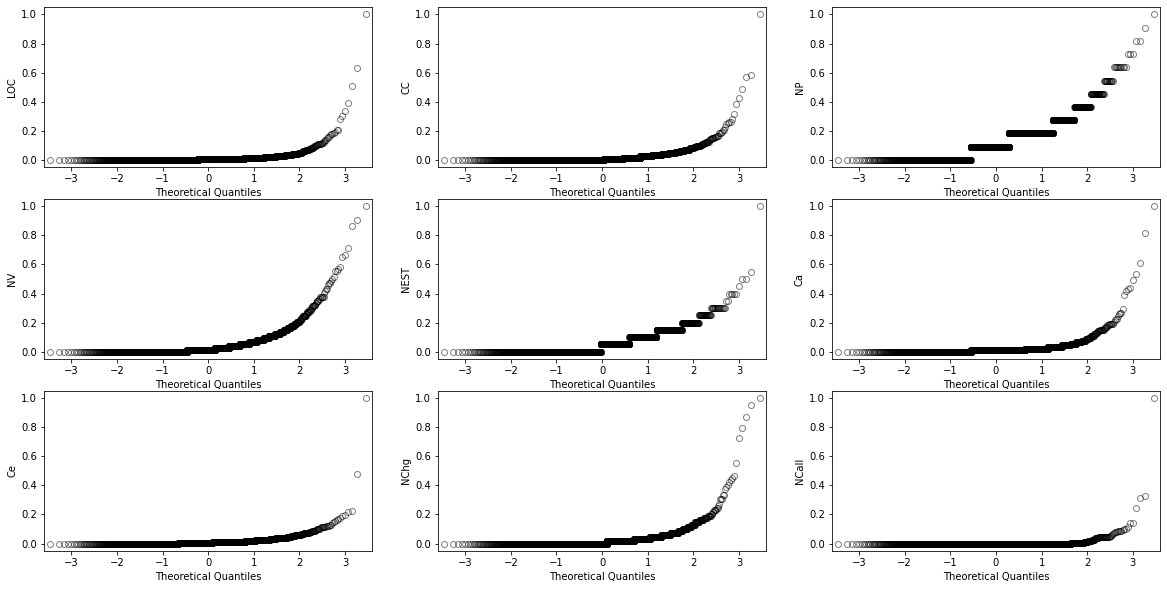

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
ax= axes.flatten()
for i in range(len(list_columns)):
    col_name = list_columns[i]
    sm.qqplot(scaled_data[col_name], marker='o', markerfacecolor='none', markeredgecolor='k', alpha=0.5,
              ax = ax[i])
    ax[i].set_ylabel(col_name)

# plt.tight_layout(pad=1.5)
# plt.show()

plt.savefig(save_to_folder + '/plots/qqplots_scaled.pdf', bbox_inches = 'tight', pad_inches = 0)

In [48]:
from collections import Counter

x = merged_left_ca['CC']
x = x[~np.isnan(x)]
print(Counter(x))

# plt.hist(x)

Counter({1.0: 1911, 2.0: 599, 3.0: 445, 4.0: 238, 5.0: 152, 6.0: 87, 7.0: 68, 8.0: 36, 10.0: 31, 9.0: 30, 11.0: 20, 13.0: 15, 12.0: 10, 17.0: 7, 15.0: 6, 20.0: 5, 16.0: 5, 14.0: 4, 19.0: 3, 22.0: 3, 21.0: 3, 24.0: 3, 34.0: 2, 27.0: 2, 18.0: 2, 55.0: 1, 37.0: 1, 128.0: 1, 63.0: 1, 50.0: 1, 41.0: 1, 32.0: 1, 30.0: 1, 75.0: 1, 33.0: 1, 73.0: 1, 25.0: 1})


In [81]:
a = {'a': 2, 'n': 4}
f = a.pop('a')
print(a)
print(f)

{'n': 4}
2
